# DAML Dataset Evaluation with NRTK Perturber
This is a notebook demonstrating how sensor and scenario perturbations from the Natural Robustness Toolkit (NRTK) affect the DP Divergence metric generated using the Data-Analysis Metrics Library (DAML).

## Table Of Contents

* [Environment Setup](#environment-setup)
* [Perturber Instantiation](#perturber-instantiation)
* [Dataset Creation](#dataset-creation)
* [Load The Model](#load-the-model)
* [Evaluate Datasets](#evaluate-datasets)

## Environment Setup <a name="environment-setup"></a>

First we install and import dependencies. This notebook assumes that the user is operating in an environment consistent with the NRTK poetry file and with NRTK already installed as well.

In [1]:
import sys

!{sys.executable} -m pip install -qU pip
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Installing alibi_detect...")
!{sys.executable} -m pip install -q alibi_detect==0.11.4
print("Installing pybsm...")
!{sys.executable} -m pip install -q pybsm
print("Installing tensorflow...")
!{sys.executable} -m pip install -q tensorflow==2.12.1
# Remove opencv-python, which requires libGL, which we don't require here, and replace with opencv-python-headless
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless

print("Done!")

Installing matplotlib...
Installing alibi_detect...
Installing pybsm...
Installing tensorflow...
Installing headless OpenCV...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nrtk 0.1.0 requires Pillow>=10.0, but you have pillow 9.5.0 which is incompatible.
Done!


In [2]:
import cv2
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

We define two helper functions. `stretch_contrast_convert_8bit` is a function that stretches the contrast to the full capacity of the image. This is used to ensure the colors in the images match before running them through the DP Divergence calculation. The second function is `crop_image` which takes in a single image in and splits it into a set of output tiles.

In [3]:
def stretch_contrast_convert_8bit(img, perc=[0.1, 99.9]):
    img = img.astype(float)
    img = img - np.percentile(img.ravel(), perc[0])
    img = img/(np.percentile(img.ravel(), perc[1])/255)
    img = np.clip(img, 0, 255)
    return np.round(img).astype(np.uint8)

In [4]:
def crop_image(img, input_size=512, output_size=64):

  """Crops a input_sizexinput_sizex3 image into a set of output_sizexoutput_sizex3 images.

  Args:
    img: A numpy array representing an image.

    input_size: the edge size of a square image

    output_size: the desired edge size of the cropped image

  Returns:
    A list of output_sizexoutput_sizex3 numpy arrays representing the cropped images.
  """

  cropped_images = []
  
  for i in range(0, input_size, output_size):
    for j in range(0, input_size, output_size):
      cropped_images.append(img[i:i + output_size, j:j + output_size, :])

  return cropped_images

## Perturber Instantiation <a name="perturber-instantiation"></a>

We next define the parameters of both the sensor and scenario objects that NRTK uses to perturb the images. From this base set of parameters, we create a set of perturbers with varying focal length and ground range parameters.

In [5]:
from nrtk.impls.perturb_image.pybsm.scenario import PybsmScenario
from nrtk.impls.perturb_image.pybsm.sensor import PybsmSensor
import pybsm

#telescope focal length (m)
f=0.6
# Telescope diameter (m)
D=0.0648

#detector pitch (m)
p=2e-05
#Optical system transmission, red  band first (m)
optTransWavelengths = np.array([0.85-.15,0.85+.15])*1.0e-6

L3 = PybsmSensor(
    # required
    name                = 'L32511x',
    D                   = D, # Telescope diameter (m)
    f                   = f, #telescope focal length (m)
    px                  = p, #detector pitch (m)
    optTransWavelengths = optTransWavelengths, #Optical system transmission, red  band first (m)

    # optional
    opticsTransmission  = 0.5*np.ones(optTransWavelengths.shape[0]), #guess at the full system optical transmission (excluding obscuration)
    eta                 = 0.4, #guess
    wx                  = p, #detector width is assumed to be equal to the pitch
    wy                  = p, #detector width is assumed to be equal to the pitch
    intTime             = 30.0e-3, #integration time (s) - this is a maximum, the actual integration time will be, determined by the well fill percentage
    darkCurrent         = pybsm.darkCurrentFromDensity(1e-5,p,p), #dark current density of 1 nA/cm2 guess, guess mid range for a silicon camera
    readNoise           = 25.0, #rms read noise (rms electrons)
    maxN                = 96000.0, #maximum ADC level (electrons)
    bitdepth            = 11.9, #bit depth
    maxWellFill         = .6, #maximum allowable well fill (see the paper for the logic behind this)
    sx                  = 0.25*p/f, #jitter (radians) - The Olson paper says that its "good" so we'll guess 1/4 ifov rms
    sy                  = 0.25*p/f, #jitter (radians) - The Olson paper says that its "good" so we'll guess 1/4 ifov rms
    dax                 = 100e-6, #drift (radians/s) - again, we'll guess that it's really good
    day                 = 100e-6, #drift (radians/s) - again, we'll guess that it's really good
    qewavelengths       = np.array([.3, .4, .5, .6, .7, .8, .9, 1.0, 1.1])*1.0e-6,
    qe                  = np.array([0.05, 0.6, 0.75, 0.85, .85, .75, .5, .2, 0])
)

S = PybsmScenario(
    name='niceday',
    ihaze=1, #weather model
    altitude=9000.0, #sensor altitude
    groundRange=0.0, #range to target

    aircraftSpeed=100.0
)

In [6]:
from nrtk.impls.perturb_image.pybsm.perturber import PybsmPerturber

#create focal length perturbers
L3.f = 0.6
fl_perturber_0 = PybsmPerturber(L3, S)
L3.f = 0.4
fl_perturber_1 = PybsmPerturber(L3, S)
L3.f = 0.2
fl_perturber_2 = PybsmPerturber(L3, S)
L3.f = 0.1
fl_perturber_3 = PybsmPerturber(L3, S)
fl_perturbers = [fl_perturber_0, fl_perturber_1, fl_perturber_2, fl_perturber_3]

#reset f for the ground range perturbers
L3.f = 0.6

#create ground range perturbers
S.groundRange = 0
gr_perturber_0 = PybsmPerturber(L3, S)
S.groundRange = 5000
gr_perturber_1 = PybsmPerturber(L3, S)
S.groundRange = 10000
gr_perturber_2 = PybsmPerturber(L3, S)
S.groundRange = 15000
gr_perturber_3 = PybsmPerturber(L3, S)
gr_perturbers = [gr_perturber_0, gr_perturber_1, gr_perturber_2, gr_perturber_3]

## Dataset Creation <a name="dataset-creation"></a>

After loading the perturbers we load in a set of 10 xView images, run them through each of the perturbers, and crop the images to get a set of 64x64 sized perturbed output images. Additionally we load in a set of 10 unperturbed xView images that are cropped to the same size as the perturbed images.

In [7]:
#prepare focal length perturbed dataset
im_folder = "./daml/data/perturbed/"
crop_size = 64
reshape = (512, 512)
fl_datasets = []

for perturber in fl_perturbers:
    perturbed_ims = []
    for file in os.listdir(im_folder):
        im = cv2.imread(im_folder + file)
        im = perturber(im, {"img_gsd": 0.3})
        im = cv2.resize(im, reshape, interpolation=cv2.INTER_AREA)
        im = stretch_contrast_convert_8bit(im)
        cropped_images = crop_image(im, im.shape[0], crop_size)
        perturbed_ims.extend(cropped_images)
    fl_perturbed_ims = np.array(perturbed_ims)
    fl_datasets.append(fl_perturbed_ims)

In [8]:
#prepare ground range perturbed dataset
im_folder = "./daml/data/perturbed/"
perturbed_ims = []
gr_datasets = []

for perturber in gr_perturbers:
    perturbed_ims = []
    for file in os.listdir(im_folder):
        im = cv2.imread(im_folder + file)
        im = perturber(im, {"img_gsd": 0.3})
        im = cv2.resize(im, reshape, interpolation=cv2.INTER_AREA)
        im = stretch_contrast_convert_8bit(im)
        cropped_images = crop_image(im, im.shape[0], crop_size)
        perturbed_ims.extend(cropped_images)
    gr_perturbed_ims = np.array(perturbed_ims)
    gr_datasets.append(gr_perturbed_ims)

In [9]:
#prepare unperturbed dataset
im_folder = "./daml/data/unperturbed/"
crop_size = 64
unperturbed_ims = []
for file in os.listdir(im_folder):
    im = cv2.imread(im_folder + file)#, cv2.COLOR_BGR2GRAY)
    im = stretch_contrast_convert_8bit(im)
    cropped_images = crop_image(im, im.shape[0], crop_size)
    unperturbed_ims.extend(cropped_images)

unperturbed_ims = np.array(unperturbed_ims)

## Load the Model <a name="load-the-model"></a>

Next to finish the preparation steps we load in an encoder extracted from an instance of the AE class from `daml.metrics.outlier_detection` that has been trained on cropped chips from xView images. The encoder that is loaded in was trained on the entire set of xView images located in the folder here: https://gitlab.jatic.net/jatic/demos/-/tree/main/increment2/supporting_files/satellite_te/xview/chipped?ref_type=heads

These images were then cropped into 64x64 sized tiles.

In [10]:
#Load encoder from .pkl file
encoder_file = "./daml/model/xview_encoder.pkl"

with open(encoder_file, 'rb') as outp:
    encoder = pickle.load(outp)

2023-12-04 09:47:33.009233: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 09:47:33.032139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 09:47:34.340983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-04 09:47:37.976320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

## Evaluate Datasets <a name="evaluate-datasets"></a>

Finally we generate features for the set of unperturbed images, focal length perturbed images, and ground range perturbed images.
Once we have the encodings we can compare the perturbed image features against the unperturbed image features to get the DP Divergence values.

In [11]:
from daml.metrics.divergence.aria import HP_FNN

#Run images through encoder, extract features, and compare with dpdivergence
metric = HP_FNN()
fl_results = []
gr_results = []

unperturbed_feats = encoder(unperturbed_ims)
for i in range(len(fl_datasets)):
    fl_perturbed_feats = encoder(fl_datasets[i])
    gr_perturbed_feats = encoder(gr_datasets[i])

    fl_dp_divergence = metric.evaluate(dataset_a=unperturbed_feats, dataset_b=fl_perturbed_feats)
    gr_dp_divergence = metric.evaluate(dataset_a=unperturbed_feats, dataset_b=gr_perturbed_feats)

    fl_results.append(fl_dp_divergence.dpdivergence)
    gr_results.append(gr_dp_divergence.dpdivergence)

Below are the DP Divergence values for each perturbation metric when measured against the unperturbed images. The red dashed line indicates the parameter value of the simulated image with the estimated parameters of the camera, and the DP Divergence generally increases as each metric gets further away from the starting parameter. 

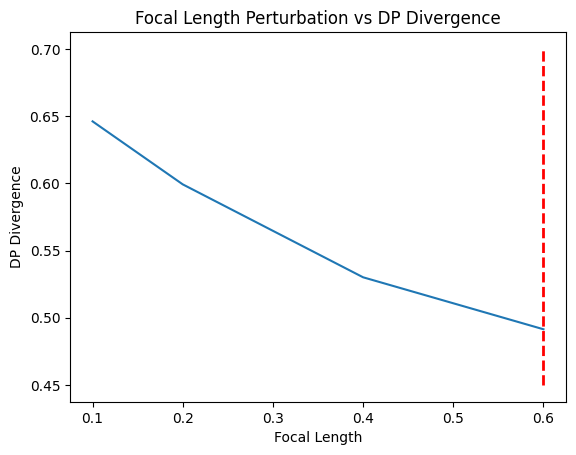

In [12]:
f = [0.6, 0.4, 0.2, 0.1]

plt.title("Focal Length Perturbation vs DP Divergence")
plt.xlabel("Focal Length")
plt.ylabel("DP Divergence")
plt.vlines(x=[0.6], ymin=0.45, ymax=0.7, colors='red', ls='--', lw=2, label='Original Image Focal Length')

plt.plot(f, fl_results)

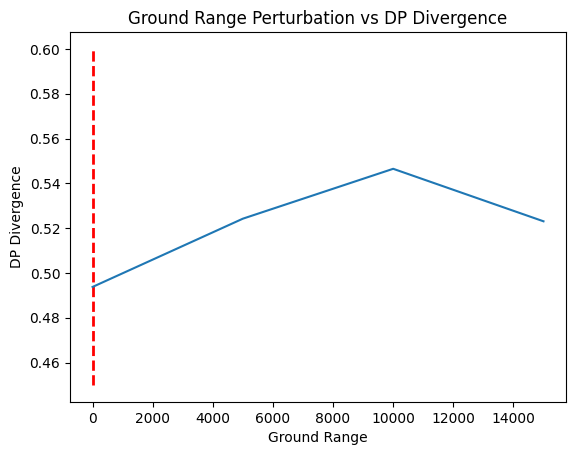

In [13]:
gr = [0, 5000, 10000, 15000]

plt.title("Ground Range Perturbation vs DP Divergence")
plt.xlabel("Ground Range")
plt.ylabel("DP Divergence")
plt.vlines(x=[0], ymin=0.45, ymax=0.6, colors='red', ls='--', lw=2, label='Original Image Ground Range')

plt.plot(gr, gr_results)